# Модель Океана
## Выполнил Ахматнуров Марат

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import random
from time import sleep

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython import display

In [3]:
def noise_data(data, noise):
    return data + noise


## Существа

In [38]:
class Creature(object):
    def __init__(self,
                 lifespan=85, puberty=16, fertility=.3, family='Creature'):
        if lifespan <= 0:
            lifespan = 2
        if puberty <= 0:
            puberty = 1
        self._lifespan = lifespan
        self._puberty = puberty
        self._fertility = fertility
        self._family = family
        self._years = 0

    def grown_up(self):
        self._years += 1
        return self._years < self._lifespan

    def get_child(self, noise_spread=0):
        pass

    def check_pregnancy(self):
        return (self._years > self._puberty) and\
               random.uniform(0, 1) < self._fertility

    def get_family(self):
        return self._family


class Herbivore(Creature):
    def __init__(self,
                 lifespan=85, puberty=16, fertility=.3, family='Herbivore'):
        Creature.__init__(self, lifespan, puberty, fertility, family)

    def get_child(self, noise_spread=0):
        if self.check_pregnancy():
            noise_spread = abs(noise_spread)
            return Herbivore(noise_data(self._lifespan,
                                        random.randint(-noise_spread,
                                                       noise_spread)),
                             noise_data(self._puberty,
                                        random.randint(-noise_spread,
                                                       noise_spread)),
                             self._fertility,
                             self._family)
        else:
            return None


class Predator(Creature):
    def __init__(self, lifespan=80, puberty=20,
                 fertility=.25, appetite=7, family='Predator'):
        Creature.__init__(self, lifespan, puberty, fertility, family)
        if appetite <= 0:
            appetite = 1
        self._appetite = appetite
        self._hungry = 0

    def grown_up(self):
        self._hungry += 1
        return (self._hungry < self._appetite) and Creature.grown_up(self)

    def is_hungry(self):
        return self._hungry > (self._appetite * .5)

    def eat(self):
        self._hungry = -1

    def get_child(self, noise_spread=0):
        if self.check_pregnancy():
            noise_spread = abs(noise_spread)
            return Predator(noise_data(self._lifespan,
                                       random.randint(-noise_spread,
                                                      noise_spread)),
                            noise_data(self._puberty,
                                       random.randint(-noise_spread,
                                                      noise_spread)),
                            self._fertility,
                            noise_data(self._appetite,
                                       random.randint(-noise_spread,
                                                      noise_spread)),
                            self._family)
        else:
            return None

Базовое существо является жервтой. Имеет следующие аттрибуты:
*   *lifespan* - продолжительность жизни
*   *puberty* - возраст половой зрелости
*   *fertility* - вероятность дать потомство
*   *years* - возраст
*   *family* - метка семьи (по умолчанию тип существа)

Хищник тоже существо, но в дополнение имеет аттрибуты:
*   *appetite* - сколько может продержаться без еды
*   *hungry* - прошешее с последнего приема пищи время

Океанская живность имеет методы:
*   *grown_up* - взросление, возвращает булево значение, продолжает ли существо жизнь
*   *eat* - утоление голода (у хищников)
*   *get_child* - рождение потомства, параметр _noise_ задает шум в временные параметры для детей, возможно так даже получится сымитировать эволюцию на отдельных "семьях"(например дитя живет на 5 периодов больше, внук прибавит еще 4, итого рост продолжительности жизни в двух поколениях. хотя в целом по океану он останется прежним. Из желания имитировать эволюцию не будет проверки, что существо в течение жизни способно дать потомство, возможно это приведет к вымиранию некоторых семей)
*   *check_pregnancy* - вспомогательная функция, проверка что существо готово дать потомство
*   *get_family* - возвращает метку семьи к которой принадлежит существо
*   *is_hungry* - чувство голода у хищника, сытый хищник не будет никого кушать

## Океан

In [71]:
class Cell(object):
    def __init__(self, value=None):
        self.age = 0
        self._value = value

    def __int__(self):
        if self._value is None:
            return 0
        if isinstance(self._value, Predator):
            return 9
        if isinstance(self._value, Creature):
            return 5
        return 1

    def __str__(self):
        return str(int(self))

    def is_empty(self):
        return self._value is None

    def who_is(self):
        return type(self._value)

    def swap(self, other):
        other.age = self.age
        if isinstance(self._value, Predator) and\
                isinstance(other._value, Herbivore):
            self._value.eat()
            other.set_cell(None)
        self._value, other._value = other._value, self._value

    def period(self):
        self.age += 1
        if isinstance(self._value, Creature):
            if not(self._value.grown_up()):
                self.set_cell(None)

    def set_cell(self, value):
        self._value = value

    def passport(self):
        if not isinstance(self._value, Creature):
            return None
        passport = vars(self._value)
        passport['race'] = self._value.__class__.__name__
        return passport

    def reproduce(self, evo):
        if isinstance(self._value, Creature):
            return self._value.get_child(evo)
        return None


class Ocean(object):
    def __init__(self, size, epoch_length, evo=5, border_count=None,
                 herbivore_count=None, predator_count=None,
                 herbivore_lifespan=85, predator_lifespan=80,
                 herbivore_puberty=16, predator_puberty=15,
                 herbivore_fertility=.07, predator_fertility=.05,
                 predator_appetite=10,
                 herbivores_family=('Herb0', 'Herb1',
                                    'Herb3', 'Herb4', 'Herb5'),
                 predators_family=('Pred0', 'Pred1',
                                   'Pred3', 'Pred4', 'Pred5')):
        self.__width = size[0]
        self.__height = size[1]
        self.__epoch = epoch_length
        self.__evo = evo
        self.__ocean = ([([Cell() for i in range(self.__width)])
                        for i in range(self.__height)])
        self.age = 0
        if border_count is None:
            border_count = int(self.__width * self.__height * 0.1)
            print >> sys.stderr, 'Default value for borders count:',
            print >> sys.stderr,  border_count, '(10% of Ocean)'
        if herbivore_count is None:
            herbivore_count = int(self.__width * self.__height * 0.2)
            print >> sys.stderr, 'Default value for herbivores count:',
            print >> sys.stderr,  herbivore_count, '(20% of Ocean)'
        if predator_count is None:
            predator_count = int(self.__width * self.__height * 0.20)
            print >> sys.stderr, 'Default value for predators count:',
            print >> sys.stderr, predator_count, '(20% of Ocean)'
        while border_count > 0:
            coordinates = (random.randrange(self.__height),
                           random.randrange(self.__width))
            if self.__ocean[coordinates[0]][coordinates[1]].is_empty():
                self.__ocean[coordinates[0]][coordinates[1]] = Cell(True)
                border_count -= 1
        while predator_count > 0:
            coordinates = (random.randrange(self.__height),
                           random.randrange(self.__width))
            family = predators_family[predator_count % len(predators_family)]
            if self.__ocean[coordinates[0]][coordinates[1]].is_empty():
                self.__ocean[coordinates[0]][coordinates[1]] =\
                    Cell(Predator(predator_lifespan,
                                  predator_puberty,
                                  predator_fertility,
                                  predator_appetite,
                                  family))
            predator_count -= 1
        while herbivore_count > 0:
            coordinates = (random.randrange(self.__height),
                           random.randrange(self.__width))
            family = herbivores_family[herbivore_count % len(herbivores_family)]
            if self.__ocean[coordinates[0]][coordinates[1]].is_empty():
                self.__ocean[coordinates[0]][coordinates[1]] =\
                    Cell(Herbivore(herbivore_lifespan,
                                   herbivore_puberty,
                                   herbivore_fertility,
                                   family))
            herbivore_count -= 1

    def __str__(self):
        return str(self.snapshot())

    def snapshot(self):
        res = map(lambda line: map(int, line), self.__ocean)
        return res

    def __default_family_album(self):
        return {'members_count': 0,
                'lifespan': [],
                'puberty': [],
                'appetite': []}

    def __update_family_album(self, album, passport):
        album['members_count'] += 1
        album['lifespan'].append(passport['_lifespan'])
        album['puberty'].append(passport['_puberty'],)
        album['appetite'].append(passport.get('_appetite', 0))

    def snapshot_detailed(self):
        family_albums = {}
        for i in range(self.__height):
            for j in range(self.__width):
                passport = self.__ocean[i][j].passport()
                if passport is None:
                    continue
                if passport['race'] not in family_albums:
                    family_albums[passport['race']] =\
                        self.__default_family_album()
                if passport['_family'] not in family_albums:
                    family_albums[passport['_family']] =\
                        self.__default_family_album()
                self.__update_family_album(family_albums[passport['race']],
                                           passport)
                self.__update_family_album(family_albums[passport['_family']],
                                           passport)
        return self.snapshot(), family_albums

    def __check_neighbours(self, i, j):
        empties = []
        herbivores = []
        for neighbour_i in range(i-1, i+2, 2):
            neighbour_j = j
            if (neighbour_i >= 0 and neighbour_i < self.__height):
                neighbour = self.__ocean[neighbour_i][neighbour_j]
                if (neighbour.who_is() == Herbivore):
                    herbivores.append((neighbour_i, neighbour_j))
                if (neighbour.is_empty()):
                    empties.append((neighbour_i, neighbour_j))
        for neighbour_j in range(j-1, j+2, 2):
            neighbour_i = i
            if (neighbour_j >= 0 and neighbour_j < self.__width):
                neighbour = self.__ocean[neighbour_i][neighbour_j]
                if (neighbour.who_is() == Herbivore):
                    herbivores.append((neighbour_i, neighbour_j))
                if (neighbour.is_empty()):
                    empties.append((neighbour_i, neighbour_j))
        return empties, herbivores

    def __update_cell(self, i, j):
        if self.__ocean[i][j].age > self.age:
            return  # already update
        self.__ocean[i][j].period()
        if self.__ocean[i][j].is_empty():
            return  # no one's living here
        empties, herbivores = self.__check_neighbours(i, j)
        if isinstance(self.__ocean[i][j]._value, Predator):
            if (len(herbivores) > 0 and
                    self.__ocean[i][j]._value.is_hungry()):
                victim = herbivores[random.randrange(len(herbivores))]
                self.__ocean[i][j].swap(self.__ocean[victim[0]]
                                                    [victim[1]])
                return
        if isinstance(self.__ocean[i][j]._value, Creature):
            if (len(empties) > 0):
                move_to = empties[random.randrange(len(empties))]
                child = self.__ocean[i][j].reproduce(self.__evo)
                if child is None:
                    (self.__ocean[i][j]
                         .swap(self.__ocean[move_to[0]][move_to[1]]))
                else:
                    (self.__ocean[move_to[0]][move_to[1]]
                         .set_cell(child))
            return

    def period(self):
        if random.randint(0, 1) == 1:
            direct_line = range(self.__height)
        else:
            direct_line = range(self.__height - 1, 0, -1)
        if random.randint(0, 1) == 1:
            direct_column = range(self.__width)
        else:
            direct_column = range(self.__width - 1, 0, -1)
        for i in direct_line:
            for j in direct_column:
                self.__update_cell(i, j)
        self.age += 1
        return self.age <= self.__epoch

Ячейка океана имеет следующие методы:
*   *is_empty* - проверка ячейки на пустоту  
*   *who_is* - тип содержимого ячейки
*   *swap* - обменять содержимое ячеек
*   *period* - оторвать лист календаря
*   *set_cell* - установить содержимое
*   *passport* - паспорт жителя ячейки
*   *reproduce* - размножение жителя ячейки
        
Сам **океан** имеет следующие аттрибуты:
*   *width* и *height* - размеры матрицы океана 
*   *epoch* - длительность эры
*   *evo* - уровень эволюции
*   *ocean* - матрица океана
*   *age* - год
               
 и методы:
*   *snapshot* - простой снимок океана, его матрица
*   *snapshot_HD* - подробный снимок, включает в себя результаты переписи населения
*   *default_family_album(self)* - вспомогательный метод для переписи
*   *update_family_album* - вспомогательный метод для переписи
*   *period* - прошествие периода
*   *update_cell* - обновление ячейки, вспомогательный метод
*   *check_neighbours* - рассмотрение соседних клеток (движение только по вертикалям и диагоналям)

Направление обхода случайно выбирается каждый "год", так как иначе заметна миграция на "северо-запад" океана

Default value for borders count: 250 (10% of Ocean)


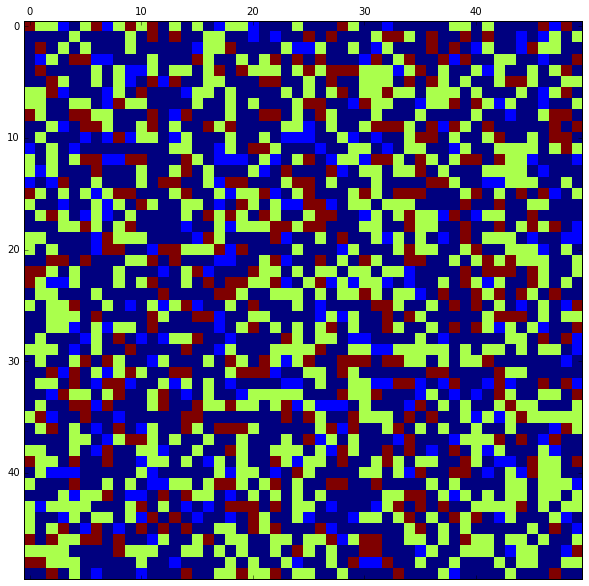

In [85]:
random.seed()
ocean = Ocean((50,50),5000, 
              predator_count=400, herbivore_count=700, 
              predator_appetite=14, predator_lifespan=85,
              herbivore_fertility=.07, predator_fertility=.05)
arr = np.array(ocean.snapshot())
plt.matshow(arr, fignum=100)

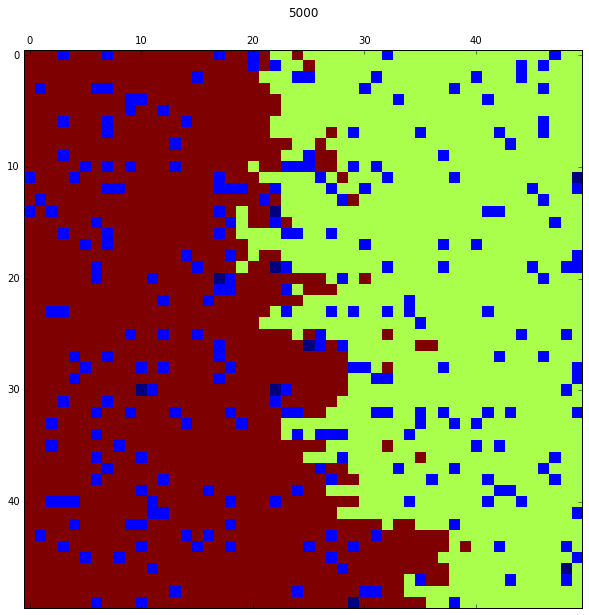

None

In [86]:
albums = [ocean.snapshot_detailed()[1]]
while (ocean.period()):
    snapshot, album = ocean.snapshot_detailed()
    albums.append(album)
    arr = np.array(snapshot)
    plt.matshow(arr, fignum=100, vmin=0, vmax=9)
    display.clear_output(wait=True)
    plt.title( ocean.age)
    display.display(plt.show())
    sleep(.05)

### Подведение итогов

Текстовые выводы относятся только к данному эксперименту, повторный эксперимент может дать другие результаты

In [87]:
def get_family_album(albums, family):
   return map(lambda x: x.get(family, {}), albums)

def get_family_statistics(album, statistics):
   return map(lambda x: x.get(statistics, []), album)


In [93]:
def plot_stat(stat_key, albums, since=0, till=None):
    if till is None:
        till = len(albums)
    time = np.arange(since, till)
    fig, axes = plt.subplots(3, sharex=True, figsize =(20, 15))
    for family in sorted(albums[0].keys()):
        data = np.array(map(lambda x: np.array(x).mean(), 
                        get_family_statistics(get_family_album(albums,
                                                               family),
                                              stat_key))[since:till])
        if 'Pred' in family:
            axes[0].plot(time, data, label=family)
        else:
            axes[2].plot(time, data, label=family)
        if family == 'Predator' or family == 'Herbivore':
            axes[1].plot(time,data, label=family)
    axes[0].set_title(stat_key+': Predators')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes[1].set_title(stat_key+': Predators VS Herbivores')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes[2].set_title(stat_key+': Herbivores')
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        

### Популяция

В самом начале хищники и травоядные равномерно распределены по океану, это привело к резкому падению популяции травоядных (так как хищники в то время еще были сильно голодными) и практически синхронно вымирали голодные хищники.
В какой-то момент хищники едва не вымерли окончательно, оставшись без еды, но падение их численности привело к росту популяции травоядных, вскоре они уже занимали 80% океанского пространства, что спасло хищников от вымирания.
Примерно к 3000му периоду травоядные и хищники стали занимать равные доли океана, их число стало более-менее стабильным. Также после 1000 периодов ареал обитания разных видов не претерпевал изменений, хищники жили на западе, травоядные на востоке

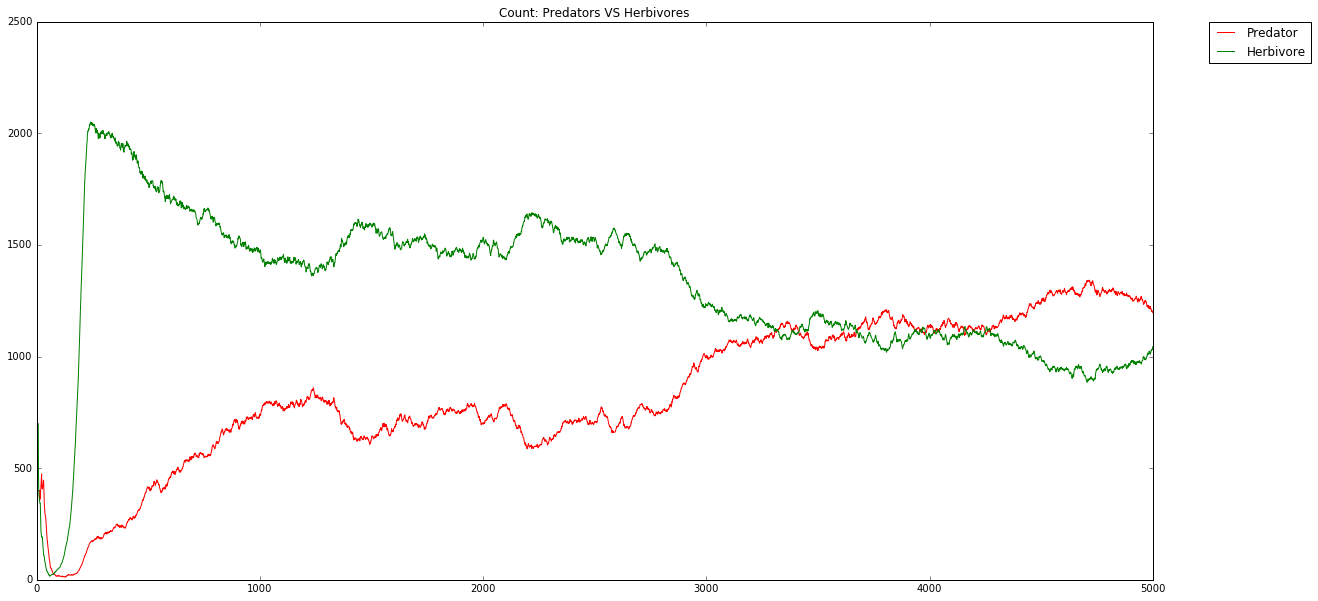

In [91]:
predators_count = count = np.array(get_family_statistics(get_family_album(albums,
                                                                          'Predator'),
                                                         'members_count'))
herbivores_count = count = np.array(get_family_statistics(get_family_album(albums,
                                                                           'Herbivore'),
                                                          'members_count'))

time = np.arange(len(albums))
plt.plot(time, predators_count, 'r', label='Predator')
plt.plot(time, herbivores_count, 'g', label='Herbivore')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Count: Predators VS Herbivores')
plt.show()

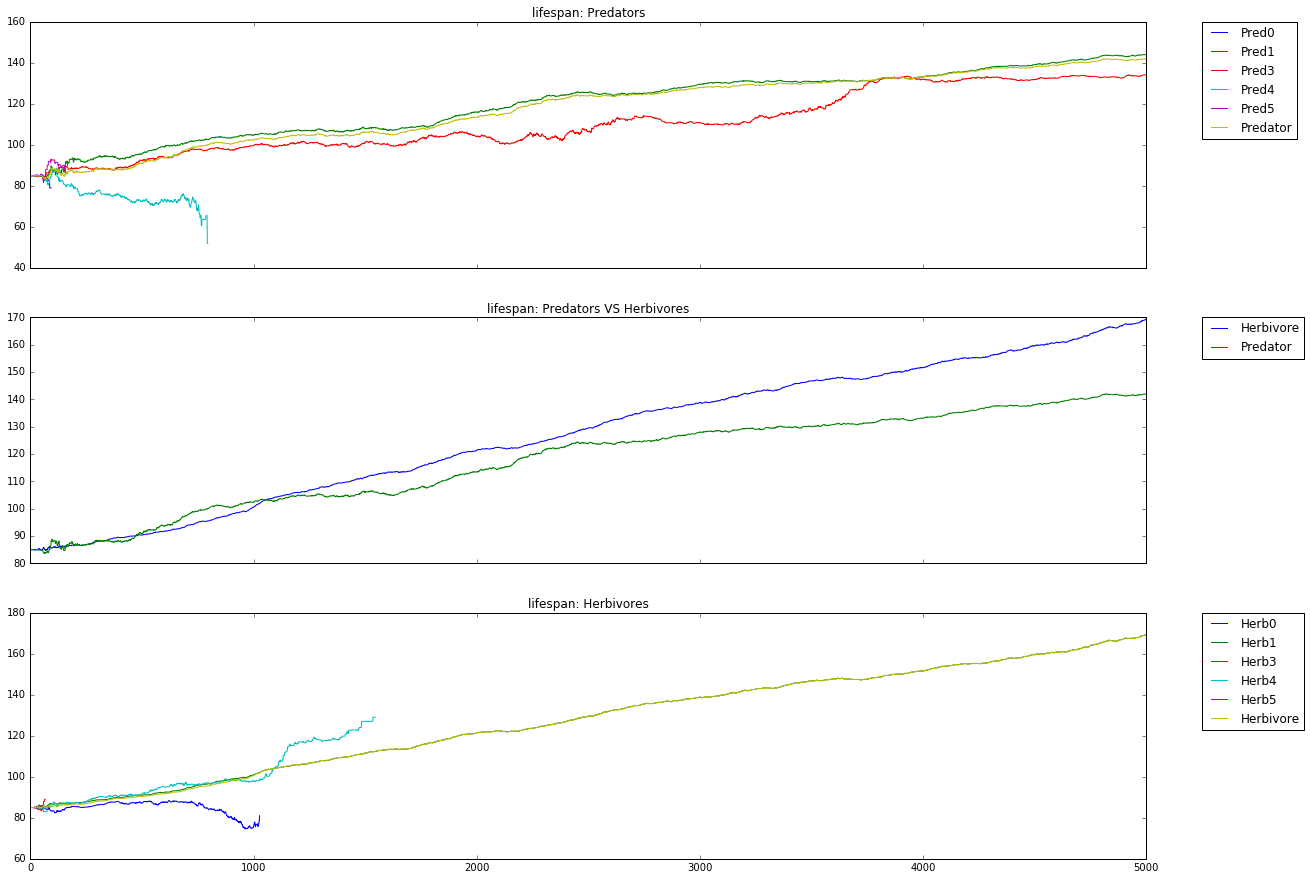

In [95]:
plot_stat('lifespan', albums)

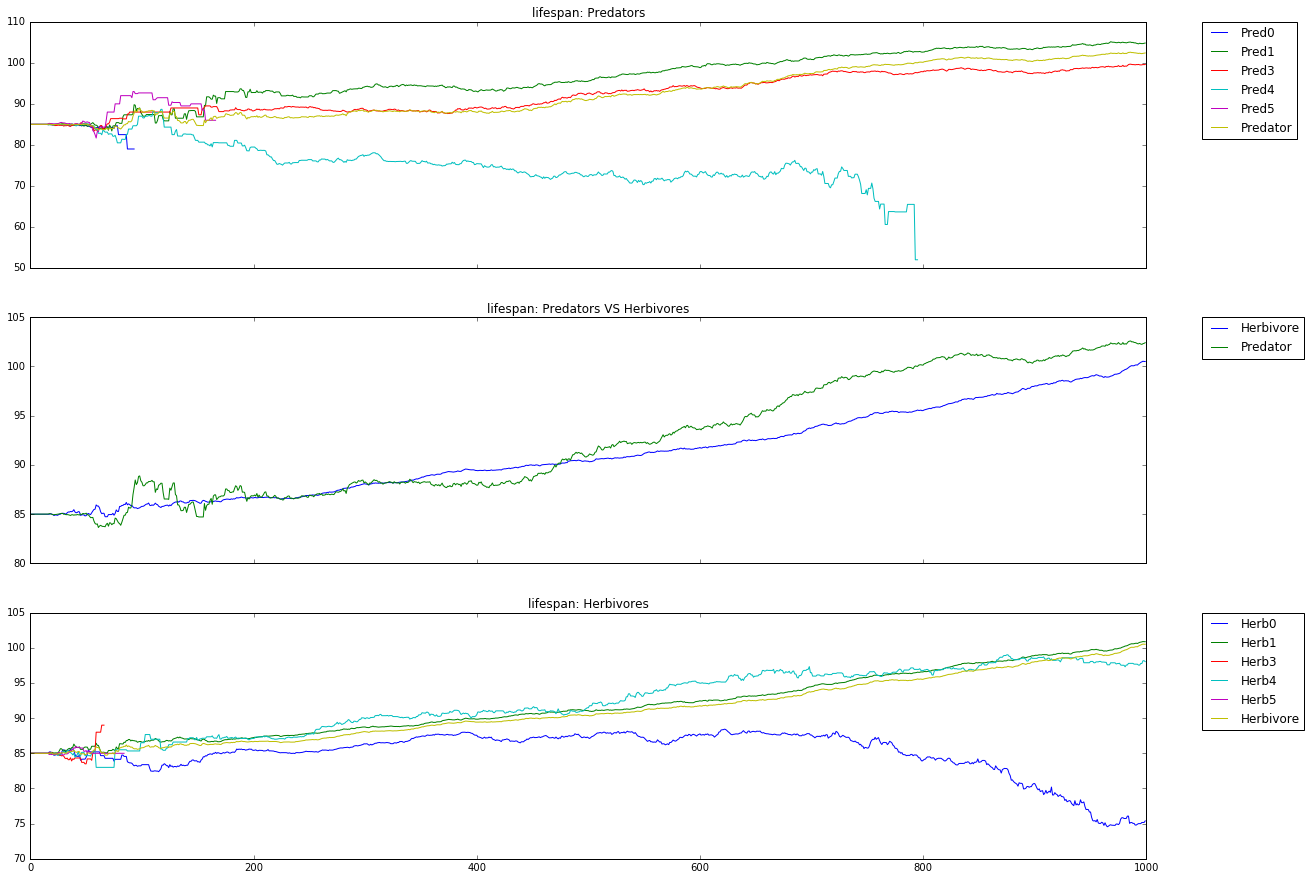

In [94]:
plot_stat('lifespan', albums,0,1000)

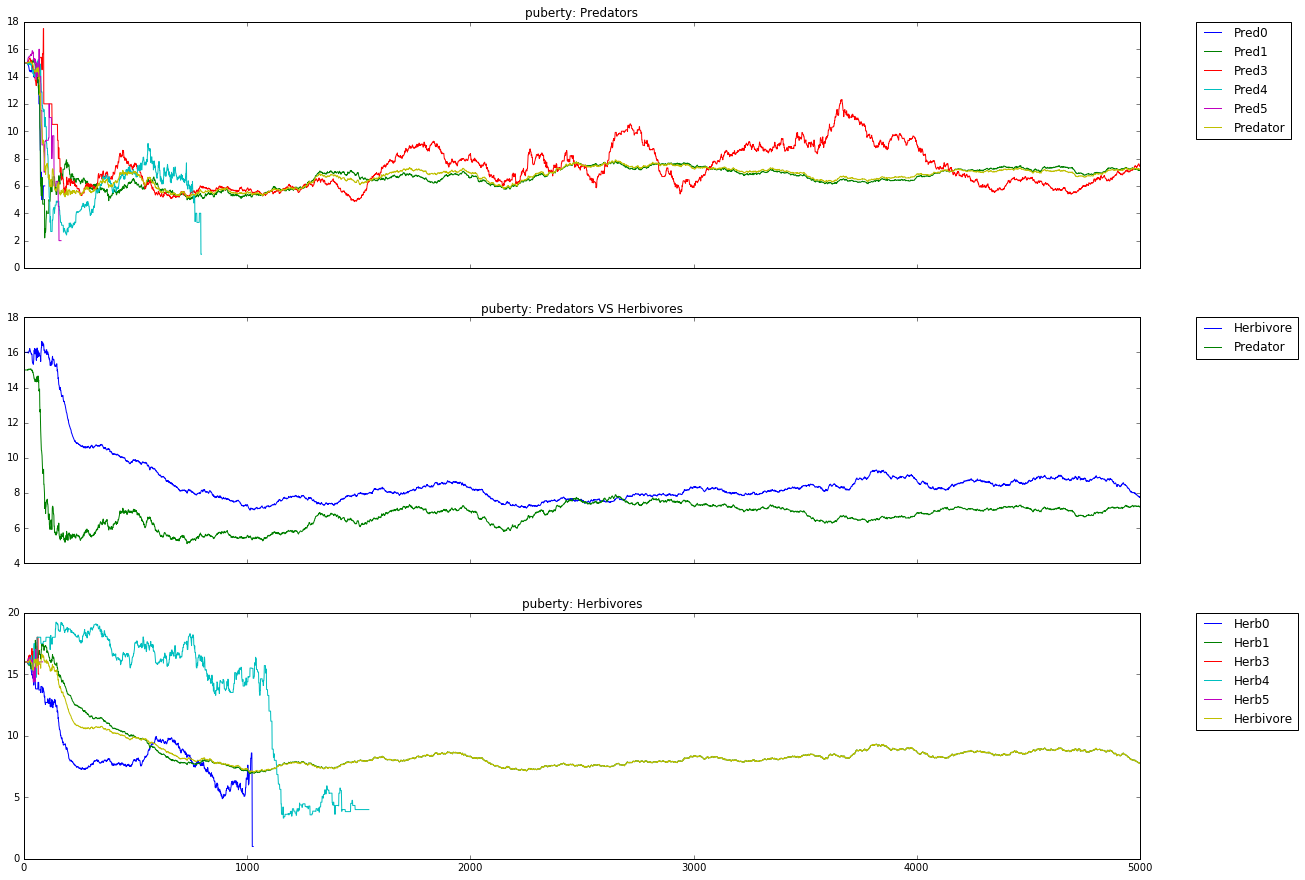

In [96]:
plot_stat('puberty', albums)

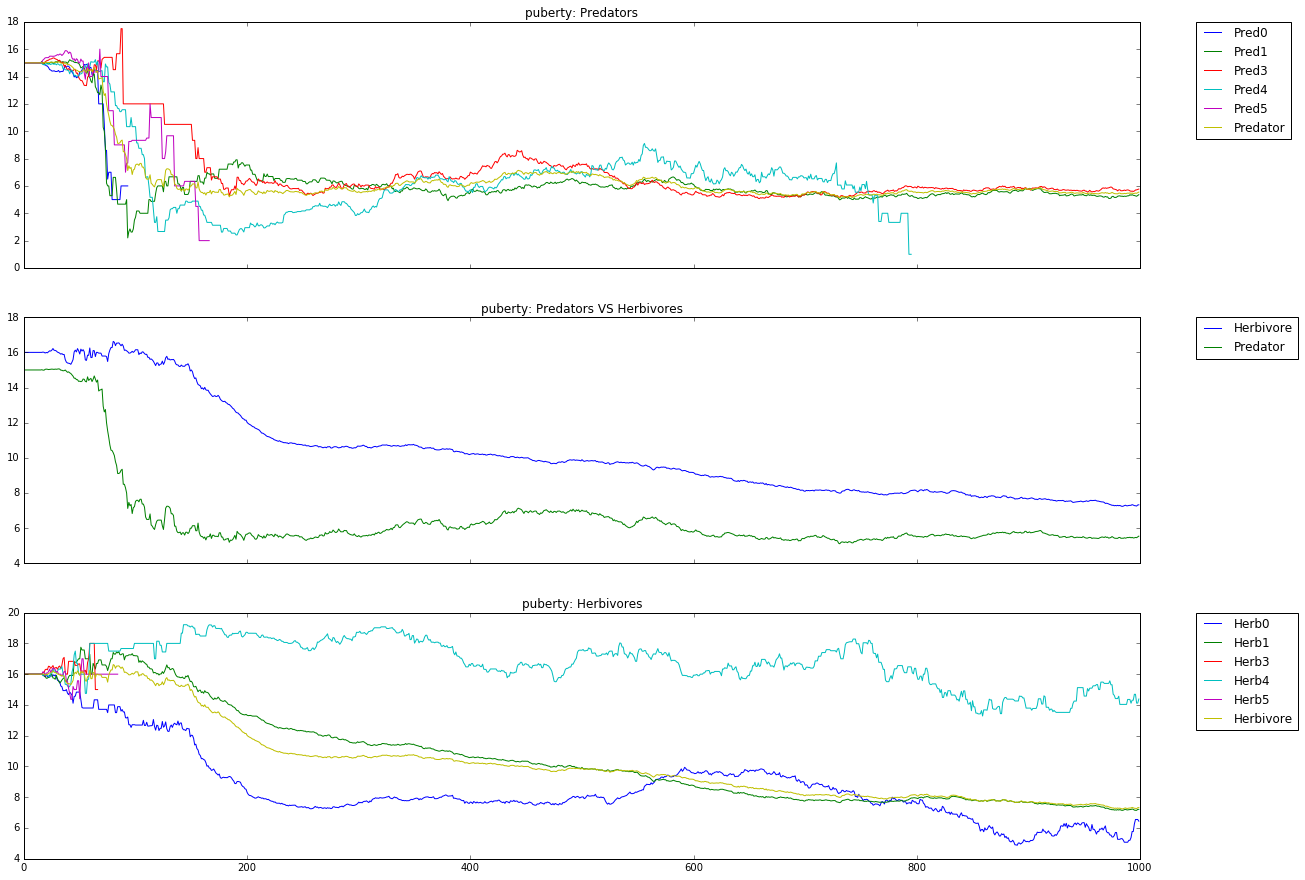

In [97]:
plot_stat('puberty', albums, 0, 1000)

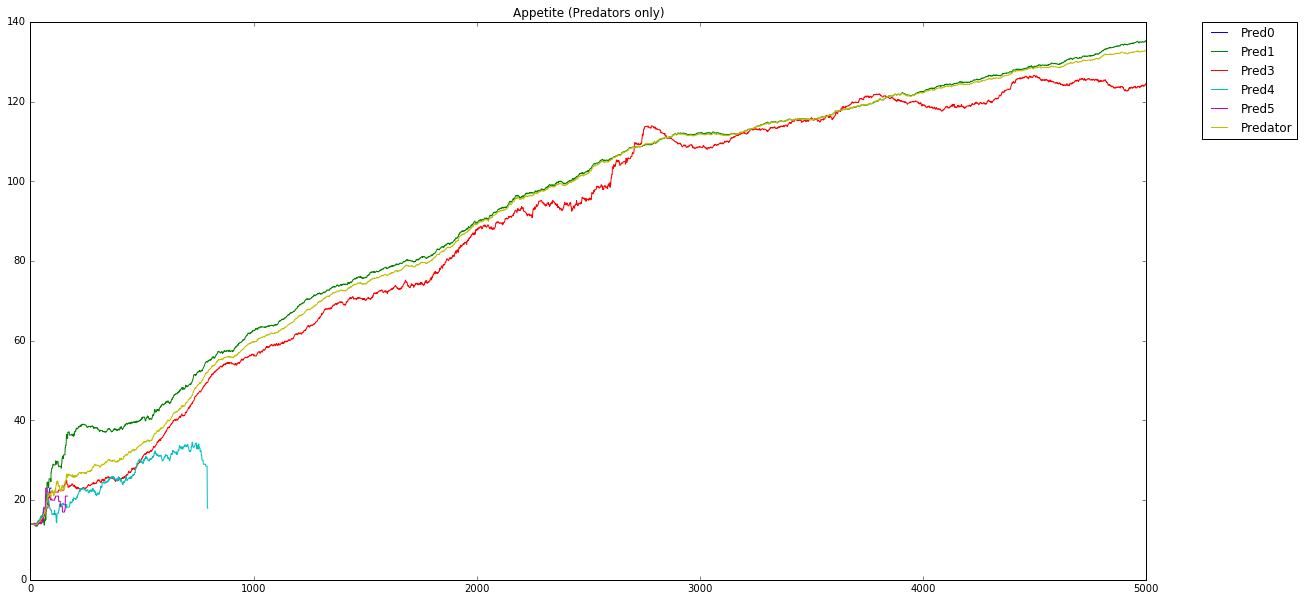

In [98]:
time = np.arange(len(albums))
for family in sorted(albums[0].keys()):
    if 'Pred' not in family:
        continue
    appetite = np.array(map(lambda x: np.array(x).mean(), 
                            get_family_statistics(get_family_album(albums,
                                                                   family),
                                                  'appetite')))
    
    plt.plot(time, appetite, label=family)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Appetite (Predators only)')
plt.show()

Глядя на графики характеристик, первый, напрашивающийся вывод: эволюция удалась. У отдельных семей заметно изменение биологических показателей, причем выжили действительно более приспособленные семьи, что выражается в большей продолжительности жизни и, у хищников, большим показателем значения *appetite*(сколько периодов существо способно продержаться без еды)
